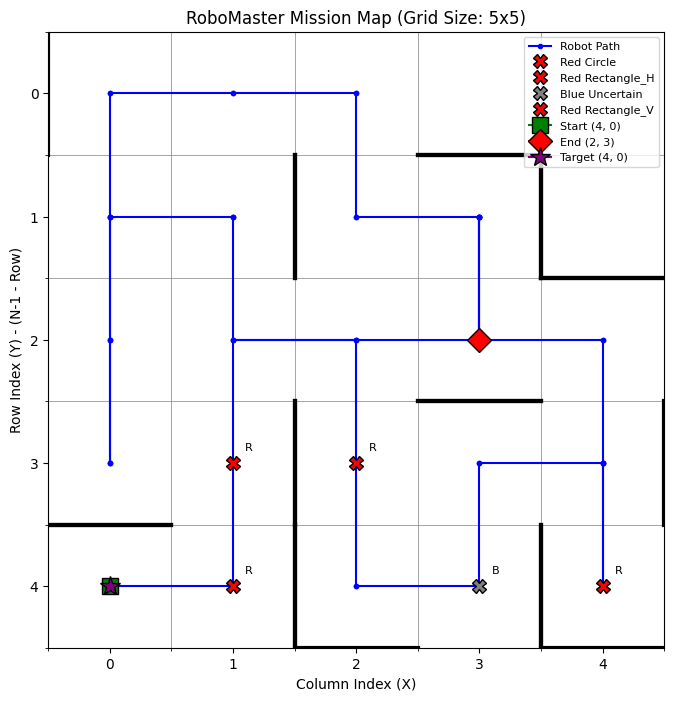

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Any, List, Tuple
# ไม่จำเป็นต้อง import matplotlib.patches เพราะตอนนี้กลับมาใช้ marker='X'

def generate_mission_map(
    # ใช้ Path เต็มเป็นค่าเริ่มต้น (Default) เพื่อให้รันได้แม้ไฟล์จะอยู่คนละโฟลเดอร์
    mapping_file: str = 'Mapping_Top.json', 
    position_file: str = 'Robot_Position_Timestamps.json', 
    detected_objects_file: str = 'Detected_Objects.json'
):
    """
    สร้างกราฟแผนที่ (Grid Map) แสดงผนัง เส้นทางการเคลื่อนที่ และวัตถุที่ตรวจจับได้
    """
    
    # 1. โหลดข้อมูลจากไฟล์ JSON
    try:
        with open(mapping_file, 'r', encoding='utf-8') as f: 
            mapping_data = json.load(f)
        with open(position_file, 'r', encoding='utf-8') as f: 
            position_data = json.load(f)
        with open(detected_objects_file, 'r', encoding='utf-8') as f: 
            objects_data = json.load(f)
    except FileNotFoundError as e:
        print(f"Error: File not found: {e.filename}")
        return
    except json.JSONDecodeError:
        print("Error: Failed to decode JSON from file.")
        return

    # 2. เตรียมข้อมูลสำหรับวาดแผนที่
    
    # ดึงขนาด Grid (สมมติว่าเป็น N x N)
    try:
        grid_size_str = position_data['session_info']['grid_size']
        N = int(grid_size_str.split('x')[0])
    except KeyError:
        print("Error: 'grid_size' not found in position data.")
        return
    
    # 3. เตรียมข้อมูลเส้นทางการเคลื่อนที่
    
    # FIX 1: ดึง position_log อย่างปลอดภัย, ถ้าไม่มีให้ใช้ list ว่าง []
    position_log = position_data.get('position_log', []) 

    # แปลง log ตำแหน่งเป็นการเคลื่อนที่ (x, y) สำหรับ Matplotlib
    # List comprehension จะสร้าง list ว่างอย่างปลอดภัยถ้า position_log ว่าง
    x_path = [log['position'][1] + 0.5 for log in position_log]
    y_path = [N - 1 - log['position'][0] + 0.5 for log in position_log] # ปรับแกน Y

    # 4. สร้างกราฟ
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # --- การตั้งค่า Ticks และ Labels ---
    ax.set_xticks(np.arange(N + 1), minor=True)
    ax.set_yticks(np.arange(N + 1), minor=True)
    ax.set_xticks(np.arange(N) + 0.5, minor=False)
    ax.set_yticks(np.arange(N) + 0.5, minor=False)
    ax.set_xticklabels(np.arange(N), minor=False)
    ax.set_yticklabels(np.arange(N)[::-1], minor=False) 
    ax.grid(True, which='minor', color='gray', linestyle='-', linewidth=0.5)
    
    # ตั้งชื่อแกน
    ax.set_xlabel("Column Index (X)")
    ax.set_ylabel("Row Index (Y) - (N-1 - Row)")
    ax.set_title(f"RoboMaster Mission Map (Grid Size: {grid_size_str})")
    
    # วาดผนัง (Walls) จาก Mapping Data
    wall_color = 'black'
    wall_width = 3.0
    
    for node in mapping_data['nodes']:
        r = node['coordinate']['row']
        c = node['coordinate']['col']
        # ปรับ Row ให้เป็นพิกัด Y บนกราฟ: 
        y_graph = N - 1 - r
        x_graph = c
        
        # วาดผนัง (ถ้า Wall Probability สูงกว่า 0.9)
        if node['wall_probabilities']['north'] > 0.9: 
            ax.plot([x_graph, x_graph + 1], [y_graph + 1, y_graph + 1], color=wall_color, linewidth=wall_width)
        if node['wall_probabilities']['south'] > 0.9: 
            ax.plot([x_graph, x_graph + 1], [y_graph, y_graph], color=wall_color, linewidth=wall_width)
        if node['wall_probabilities']['east'] > 0.9: 
            ax.plot([x_graph + 1, x_graph + 1], [y_graph, y_graph + 1], color=wall_color, linewidth=wall_width)
        if node['wall_probabilities']['west'] > 0.9: 
            ax.plot([x_graph, x_graph], [y_graph, y_graph + 1], color=wall_color, linewidth=wall_width)

    # วาดเส้นทางการเคลื่อนที่ (Path)
    ax.plot(x_path, y_path, color='blue', linestyle='-', linewidth=1.5, marker='o', markersize=3, label='Robot Path')

    # วาดวัตถุที่ตรวจจับได้ (Detected Objects) - ใช้ marker='X' เหมือนเดิม
    object_colors = {'Yellow': 'yellow', 'Red': 'red', 'Green': 'green'}
    
    # ใช้แค่ object ที่มีพิกัด Cell Position ที่ไม่ซ้ำกัน
    unique_objects = {}
    for obj in objects_data['detected_objects']:
        pos = (obj['cell_position']['row'], obj['cell_position']['col'])
        if pos not in unique_objects:
            unique_objects[pos] = obj
            
    # โค้ดวาดวัตถุด้วย marker='X'
    for pos, obj in unique_objects.items():
        r, c = pos
        x_obj = c + 0.5
        y_obj = N - 1 - r + 0.5
        
        # วาดสัญลักษณ์ของวัตถุ
        color = object_colors.get(obj['color'], 'gray')
        label = f"{obj['color']} {obj['shape']}"
        ax.plot(x_obj, y_obj, marker='X', markersize=10, color=color, markeredgecolor='black', linestyle='', label=label if label not in [l.get_label() for l in ax.get_lines()] else None)
        
        # เพิ่มข้อความระบุ (Optional)
        ax.text(x_obj + 0.1, y_obj + 0.1, f"{obj['color'][0]}", fontsize=8, color='black')

    # วาดจุดเริ่มต้นและจุดสิ้นสุด
    target_pos = position_data['session_info']['target_destination']
    
    # FIX 2: ตรวจสอบว่า position_log มีข้อมูลหรือไม่ก่อนวาด Start/End
    if position_log:
        start_pos = position_log[0]['position']
        end_pos = position_log[-1]['position']
        
        # แปลงเป็นพิกัดกราฟ
        y_start = N - 1 - start_pos[0] + 0.5
        x_start = start_pos[1] + 0.5
        y_end = N - 1 - end_pos[0] + 0.5
        x_end = end_pos[1] + 0.5
        
        ax.plot(x_start, y_start, marker='s', markersize=12, color='green', label=f'Start ({start_pos[0]}, {start_pos[1]})', markeredgecolor='black')
        ax.plot(x_end, y_end, marker='D', markersize=12, color='red', label=f'End ({end_pos[0]}, {end_pos[1]})', markeredgecolor='black')
    else:
        print("Warning: position_log is empty. Skipping plotting of Start and End positions.")


    # พิกัด Target (ดึงข้อมูลเสมอเพราะไม่ขึ้นกับ position_log)
    y_target = N - 1 - target_pos[0] + 0.5
    x_target = target_pos[1] + 0.5
    
    ax.plot(x_target, y_target, marker='*', markersize=15, color='purple', label=f'Target ({target_pos[0]}, {target_pos[1]})', markeredgecolor='black')


    # 5. แสดงกราฟ (ปรับปรุง Legend และการแสดงผล)
    ax.set_xlim(0, N)
    ax.set_ylim(0, N)

    # ปรับปรุง Legend ให้แสดงเฉพาะ Label ที่ไม่ซ้ำกัน
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize=8)

    plt.gca().set_aspect('equal', adjustable='box')
    
    # สั่งให้แสดงผล
    plt.show()

# --- การเรียกใช้งานฟังก์ชัน ---
generate_mission_map()